# multisample

In [13]:
from pathlib import Path
import re

import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse

import tarfile

def read_csv_from_tar_local(tar_path, prefer_suffix='.csv.gz', **read_csv_kwargs):
    with tarfile.open(tar_path, 'r') as tar:
        members = [m for m in tar.getmembers() if m.isfile()]
        member = next((m for m in members if m.name.endswith(prefer_suffix)), members[0])
        with tar.extractfile(member) as fh:
            compression = 'gzip' if member.name.endswith('.gz') else None
            return pd.read_csv(fh, compression=compression, **read_csv_kwargs)


data_dir = Path('/Users/christoffer/work/karolinska/Dbit-analysis/data-RNARNA')
columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_row_in_fullres',
    'pxl_col_in_fullres',
]

pattern = re.compile(r'^(?P<sample>.+)_(?P<kind>RNA_matrix|tissue_positions_list)\.csv\.tar$')
pairs = {}
for tar_path in sorted(data_dir.glob('*.tar')):
    match = pattern.match(tar_path.name)
    if match is None:
        continue
    sample_id = match.group('sample')
    kind = match.group('kind')
    pairs.setdefault(sample_id, {})[kind] = tar_path

required = {'RNA_matrix', 'tissue_positions_list'}
sample_ids = sorted([s for s, files in pairs.items() if required.issubset(files)])

if not sample_ids:
    raise ValueError(f'No complete sample pairs found in {data_dir}')

def build_sample_adata(sample_id, rna_tar, tissue_tar):
    tissue_pos = read_csv_from_tar_local(
        str(tissue_tar),
        header=None,
        names=columns,
    )
    rna_matrix = read_csv_from_tar_local(str(rna_tar), index_col=0)

    tissue_pos['barcode'] = tissue_pos['barcode'].astype(str)
    obs_df = tissue_pos.drop_duplicates('barcode').set_index('barcode')

    rna_matrix.index = rna_matrix.index.astype(str)
    rna_matrix.columns = rna_matrix.columns.astype(str)
    idx_overlap = rna_matrix.index.isin(obs_df.index).sum()
    col_overlap = rna_matrix.columns.isin(obs_df.index).sum()
    expr_df = rna_matrix if idx_overlap >= col_overlap else rna_matrix.T
    expr_df = expr_df.loc[~expr_df.index.duplicated(keep='first')]

    common_barcodes = obs_df.index.intersection(expr_df.index)
    if len(common_barcodes) == 0:
        raise ValueError(f'No overlapping barcodes for sample {sample_id}')

    obs = obs_df.loc[common_barcodes].copy()
    var = pd.DataFrame(index=expr_df.columns.astype(str))
    X = sparse.csr_matrix(expr_df.loc[common_barcodes].to_numpy())

    adata_sample = ad.AnnData(X=X, obs=obs, var=var)
    adata_sample.obs_names_make_unique()
    adata_sample.var_names_make_unique()
    adata_sample.obsm['spatial'] = adata_sample.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].to_numpy()
    adata_sample.uns['n_missing_barcodes'] = int(obs_df.index.difference(expr_df.index).size)
    adata_sample.uns['source_paths'] = {
        'rna_matrix_tar': str(rna_tar),
        'tissue_positions_tar': str(tissue_tar),
    }
    return adata_sample

sample_adatas = {}
summary_rows = []
for sample_id in sample_ids:
    rna_tar = pairs[sample_id]['RNA_matrix']
    tissue_tar = pairs[sample_id]['tissue_positions_list']
    adata_sample = build_sample_adata(sample_id, rna_tar, tissue_tar)
    sample_adatas[sample_id] = adata_sample
    summary_rows.append(
        {
            'sample_id': sample_id,
            'n_obs': adata_sample.n_obs,
            'n_vars': adata_sample.n_vars,
            'missing_barcodes': adata_sample.uns['n_missing_barcodes'],
        }
    )

adata_multi = ad.concat(
    [sample_adatas[s] for s in sample_ids],
    label='sample_id',
    keys=sample_ids,
    join='outer',
    fill_value=0,
    index_unique='-',
)
adata_multi.obs['sample_id'] = adata_multi.obs['sample_id'].astype('category')
adata_multi.obsm['spatial'] = np.asarray(adata_multi.obsm['spatial'])

multi_summary = pd.DataFrame(summary_rows).sort_values('sample_id').reset_index(drop=True)

print(adata_multi)
multi_summary


AnnData object with n_obs × n_vars = 83333 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'sample_id'
    obsm: 'spatial'


,sample_id,n_obs,n_vars,missing_barcodes
0,06_LPC5S1,8736,32285,868
1,06_LPC5S2,8169,32285,1435
2,07_LPC10S1,8180,32285,1036
3,07_LPC10S2,8928,32285,288
4,08_LPC21S1,8485,32285,1515
5,08_LPC21S2,8258,32285,1742
6,09_LPC5S1_H3K27me3,8220,32285,1780
7,09_LPC5S2_H3K27me3,8653,32285,1347
8,10_LPC21S1_H3K27me3,6299,32285,3701
9,10_LPC21S2_H3K27me3,9405,32285,595


In [14]:
import os

os.environ['NUMBA_CACHE_DIR'] = '/tmp/numba-cache'
os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'

import numba
numba.config.CACHE_DIR = os.environ['NUMBA_CACHE_DIR']

import scanpy as sc

adata_multi_pp = adata_multi.copy()
adata_multi_pp.layers['counts'] = adata_multi_pp.X.copy()

adata_multi_pp.var['mt'] = adata_multi_pp.var_names.str.upper().str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_multi_pp, qc_vars=['mt'], inplace=True, percent_top=None)

sc.pp.filter_cells(adata_multi_pp, min_counts=50)
sc.pp.filter_genes(adata_multi_pp, min_cells=3)
if adata_multi_pp.var['mt'].sum() > 0:
    adata_multi_pp = adata_multi_pp[adata_multi_pp.obs['pct_counts_mt'] < 20].copy()

sc.pp.normalize_total(adata_multi_pp, target_sum=1e4)
sc.pp.log1p(adata_multi_pp)
adata_multi_pp.raw = adata_multi_pp

sc.pp.highly_variable_genes(adata_multi_pp, flavor='seurat', n_top_genes=3000)
adata_multi_hvg = adata_multi_pp[:, adata_multi_pp.var['highly_variable']].copy()
sc.pp.scale(adata_multi_hvg, max_value=10)
sc.tl.pca(adata_multi_hvg, svd_solver='arpack')
sc.pp.neighbors(adata_multi_hvg, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_multi_hvg)
sc.tl.leiden(adata_multi_hvg, resolution=1, key_added='leiden_1')

adata_multi_pp.obs['leiden_1'] = adata_multi_hvg.obs['leiden_1']
adata_multi_pp.obsm['X_umap'] = adata_multi_hvg.obsm['X_umap']

print(adata_multi_pp)
print('HVG subset shape:', adata_multi_hvg.shape)
print('Cells per sample:')
print(adata_multi_pp.obs['sample_id'].value_counts().sort_index())


/Users/christoffer/miniconda3/envs/cellcharter-env/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 83233 × 24373
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'X_umap'
    layers: 'counts'
HVG subset shape: (83233, 3000)
Cells per sample:
sample_id
06_LPC5S1              8736
06_LPC5S2              8169
07_LPC10S1             8173
07_LPC10S2             8858
08_LPC21S1             8485
08_LPC21S2             8258
09_LPC5S1_H3K27me3     8208
09_LPC5S2_H3K27me3     8642
10_LPC21S1_H3K27me3    6299
10_LPC21S2_H3K27me3    9405
Name: count, dtype: int64


In [ ]:
import scanpy as sc

# Additional Leiden resolutions on the existing neighbor graph (adata_multi_hvg)
leiden_resolutions = [0.5, 1.0, 1.5]

for res in leiden_resolutions:
    key = f"leiden_{str(res).replace('.', 'p')}"
    sc.tl.leiden(adata_multi_hvg, resolution=res, key_added=key, flavor='leidenalg', random_state=0)
    adata_multi_pp.obs[key] = adata_multi_hvg.obs[key].astype('category')

added_cols = [f"leiden_{strså(r).replace('.', 'p')}" for r in leiden_resolutions]
print('Added clustering columns:')
print(', '.join(added_cols))

cluster_counts = {c: adata_multi_pp.obs[c].nunique() for c in added_cols}
pd.Series(cluster_counts, name='n_clusters')


Added clustering columns:
leiden_0p5, leiden_1p0, leiden_1p5


leiden_0p5    10
leiden_1p0    16
leiden_1p5    20
Name: n_clusters, dtype: int64

In [18]:
# Flip Y in-place for adata.obsm["spatial"]
xy = adata_multi_pp.obsm["spatial"].copy()
xy[:, 1] = xy[:, 1].max() - xy[:, 1]
adata_multi_pp.obsm["spatial"] = xy


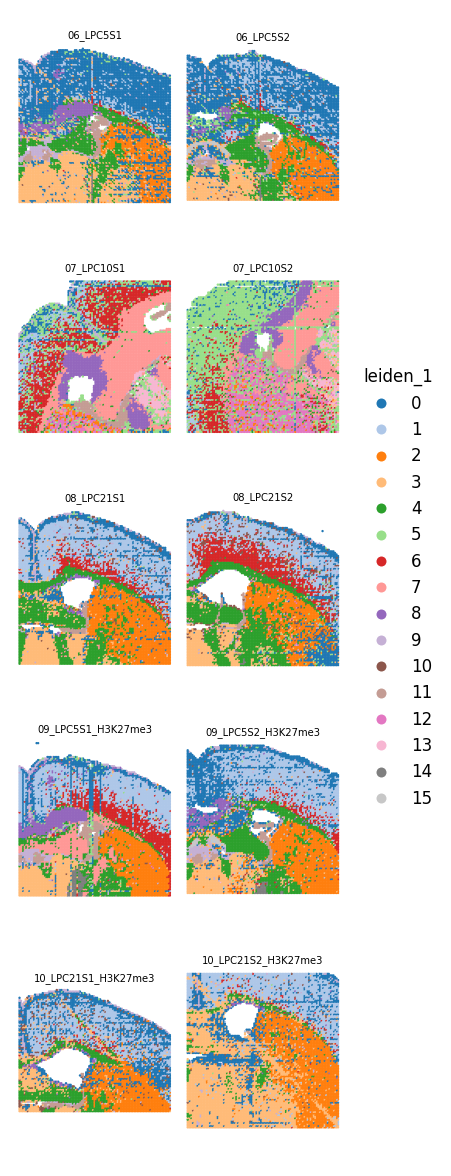

In [ ]:
from utils.spatial_utils import plot_spatial_compact_fast

plot_spatial_compact_fast(
    adata_multi_pp,
    color='leiden_1',
    groupby='sample_id',
    spot_size=2,
    cols=2,
    height=10,
);


In [20]:
adata_multi_pp.obs["condition"] = (
    adata_multi_pp.obs["sample_id"]
    .astype(str)
    .str.extract(r"(LPC\d+)", expand=False)
    .astype("category")
)


In [21]:
adata_multi_pp.obs["condition"]

GAACCAGAAACGTGAT-06_LPC5S1               LPC5
GTGACAAGAACGTGAT-06_LPC5S1               LPC5
CGGAAGAAAACGTGAT-06_LPC5S1               LPC5
GCCAAGACAACGTGAT-06_LPC5S1               LPC5
GATGAATCAACGTGAT-06_LPC5S1               LPC5
                                        ...  
GAACCAGAGCCAAGAC-10_LPC21S2_H3K27me3    LPC21
GAACCAGACGGAAGAA-10_LPC21S2_H3K27me3    LPC21
GAACCAGAGTGACAAG-10_LPC21S2_H3K27me3    LPC21
GAACCAGAGAACCAGA-10_LPC21S2_H3K27me3    LPC21
GAACCAGATTGCTGGA-10_LPC21S2_H3K27me3    LPC21
Name: condition, Length: 83233, dtype: category
Categories (3, object): ['LPC10', 'LPC21', 'LPC5']

In [22]:
adata_multi_pp

AnnData object with n_obs × n_vars = 83233 × 24373
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1', 'leiden_0p5', 'leiden_1p0', 'leiden_1p5', 'condition'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'leiden_1_colors'
    obsm: 'spatial', 'X_umap'
    layers: 'counts'

In [23]:
adata_multi_pp.write('/Volumes/processing2/dbit-nature/data/adata_multi_pp.h5ad')

In [ ]:
import pandas as pd

inp = "/Users/christoffer/Downloads/NeMO_manifest_1340989da0.tsv"
out = "/Users/christoffer/Downloads/NeMO_manifest_1340989da0_noFASTQ.tsv"

df = pd.read_csv(inp, sep="\t")

# Remove rows where ANY column contains "fastq"
mask = df.astype(str).apply(
    lambda col: col.str.contains("fastq", case=False, na=False)
).any(axis=1)

df_clean = df[~mask]

print("Original rows:", len(df))
print("Removed FASTQ rows:", mask.sum())
print("Remaining rows:", len(df_clean))

df_clean.to_csv(out, sep="\t", index=False)

Original rows: 75
Removed FASTQ rows: 32
Remaining rows: 43


In [75]:
import pandas as pd

inp = "/Users/christoffer/Downloads/NeMO_manifest_1340989da0_noFASTQ.tsv"
out = "/Users/christoffer/Downloads/NeMO_manifest_1340989da0_noFASTQ_no-frag.tsv"

df = pd.read_csv(inp, sep="\t")

# Remove rows where ANY column contains "fastq"
mask = df.astype(str).apply(
    lambda col: col.str.contains("fragments", case=False, na=False)
).any(axis=1)

df_clean = df[~mask]

print("Original rows:", len(df))
print("Removed FASTQ rows:", mask.sum())
print("Remaining rows:", len(df_clean))

df_clean.to_csv(out, sep="\t", index=False)

Original rows: 43
Removed FASTQ rows: 11
Remaining rows: 32
